In [1]:
import math
import numpy as np
import pandas as pd
from timeseriesutils import featurize

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('demo_data.csv')[['location', 'date', 'inc_hosp', 'population', 'rate']]
data.date = pd.to_datetime(data.date)
data

location       date  inc_hosp  population      rate
0           AK 2020-10-01       3.0      731545  0.410091
1           AK 2020-10-02       7.0      731545  0.956879
2           AK 2020-10-03       5.0      731545  0.683485
3           AK 2020-10-04       5.0      731545  0.683485
4           AK 2020-10-05       1.0      731545  0.136697
...        ...        ...       ...         ...       ...
13969       WY 2021-06-27      10.0      578759  1.727835
13970       WY 2021-06-28       9.0      578759  1.555051
13971       WY 2021-06-29       7.0      578759  1.209484
13972       WY 2021-06-30       8.0      578759  1.382268
13973       WY 2021-07-01       3.0      578759  0.518350

[13974 rows x 5 columns]

In [3]:
data.shape[0]

13974

# Taylor polynomial coefficients in a rolling window

The function `featurize.windowed_taylor_coefs` estimates the coefficients of a Taylor polynomial approximation to the data in a rolling window. These coefficients can be interpreted as estimates of the derivatives of an underlying smooth function based on noisy observations. The window can be `centered` at the time t, which may yield more stable estimates, but has the limitation that the treatment is inconsistent for different windows. In particular, there is not a full set of observed data in the windows at the beginning and end of the time series; in those windows, we fit to the available data. Alternatively, the window may be  `trailing` relative to the time t.

To start, we illustrate fitting a degree 1 Taylor polynomial (i.e, a line) in centered windows of size 21 for the data from California. These are the default settings.

In [4]:
ca_data = data[data.location == 'CA']
ca_data_w_deg1, feat_names = featurize.windowed_taylor_coefs(ca_data, columns='rate', fill_edges=True)
ca_data_w_deg1

location       date  inc_hosp  population      rate  \
1096       CA 2020-10-01     316.0    39512223  0.799753   
1097       CA 2020-10-02     328.0    39512223  0.830123   
1098       CA 2020-10-03     294.0    39512223  0.744074   
1099       CA 2020-10-04     315.0    39512223  0.797222   
1100       CA 2020-10-05     347.0    39512223  0.878209   
...       ...        ...       ...         ...       ...   
1365       CA 2021-06-27     162.0    39512223  0.410000   
1366       CA 2021-06-28     201.0    39512223  0.508703   
1367       CA 2021-06-29     199.0    39512223  0.503642   
1368       CA 2021-06-30     165.0    39512223  0.417592   
1369       CA 2021-07-01     188.0    39512223  0.475802   

      rate_taylor_d1_c0_w21c_sNone  rate_taylor_d1_c1_w21c_sNone  
1096                      0.819769                      0.000368  
1097                      0.817982                      0.001292  
1098                      0.814103                      0.004394  
1099                      0.819782                      0.003109  
1100                      0.822901                      0.003082  
...                            ...                           ...  
1365                      0.431006                      0.011389  
1366                      0.444475                      0.012949  
1367                      0.455778                      0.012126  
1368                      0.465702                      0.011300  
1369                      0.469015                      0.008904  

[274 rows x 7 columns]

In [5]:
feat_names

['rate_taylor_d1_c0_w21c_sNone', 'rate_taylor_d1_c1_w21c_sNone']

The same results can be achieved via a call to `featurize_data`, which allows for the calculation of multiple features at once.

In [6]:
temp = featurize.featurize_data(ca_data, group_columns=None,
                                features = [{
                                'fun': 'windowed_taylor_coefs',
                                'args': {
                                    'columns': 'rate'
                                }
                                }])
temp

(     location       date  inc_hosp  population      rate  \
 1096       CA 2020-10-01     316.0    39512223  0.799753   
 1097       CA 2020-10-02     328.0    39512223  0.830123   
 1098       CA 2020-10-03     294.0    39512223  0.744074   
 1099       CA 2020-10-04     315.0    39512223  0.797222   
 1100       CA 2020-10-05     347.0    39512223  0.878209   
 ...       ...        ...       ...         ...       ...   
 1365       CA 2021-06-27     162.0    39512223  0.410000   
 1366       CA 2021-06-28     201.0    39512223  0.508703   
 1367       CA 2021-06-29     199.0    39512223  0.503642   
 1368       CA 2021-06-30     165.0    39512223  0.417592   
 1369       CA 2021-07-01     188.0    39512223  0.475802   
 
       rate_taylor_d1_c0_w21c_sNone  rate_taylor_d1_c1_w21c_sNone  
 1096                      0.819769                      0.000368  
 1097                      0.817982                      0.001292  
 1098                      0.814103                      0.004

This augmented the data frame with the new columns `rate_taylor_d1_c0_w21c_sNone` and `rate_taylor_d1_c1_w21c_sNone` containing the estimated Taylor coefficients at each time point. In the column names, `d1` indicates that the columns store coefficients for a degree 1 Taylor polynomial, `c0` and `c1` indicate that the coefficients stored are for the degree 0 and degree 1 coefficients, `w21c` indicates that the coefficients are estimated based on rolling centered windows of length 21, and `sNone` indicates that no exponential weighting was used. We plot the estimated lines at a few representative times below:

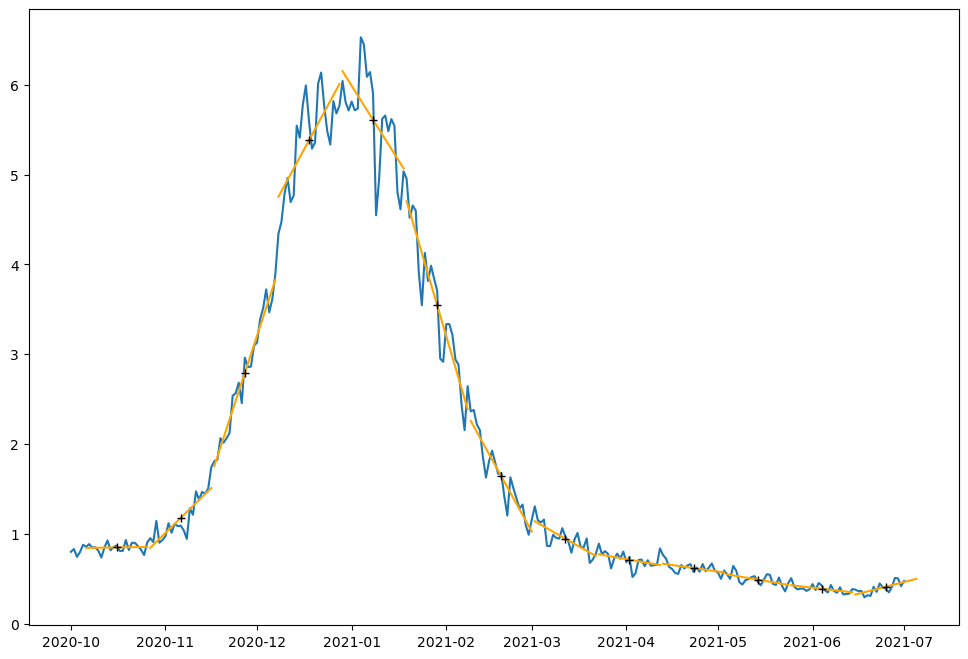

In [7]:
def plot_taylor_fits(data, taylor_degree, window_size, window_align = 'centered'):
    '''
    Helper function to plot Taylor polynomial fits.
    '''
    plt.figure(figsize = (12,8))
    plt.plot(data.date, data.rate)
    
    if window_align == 'centered':
        half_window = (window_size - 1) // 2
        window_lags = np.arange(-half_window, half_window + 1)
    elif window_align == 'trailing':
        window_lags = np.arange(-window_size, 0) + 1
    
    taylor_basis = np.concatenate(
        [np.ones((window_size, 1))] + \
            [np.expand_dims((1 / math.factorial(d)) * window_lags**d, -1) \
                for d in range(1, taylor_degree + 1)],
        axis = 1
    )
    
    for center_ind in np.arange(15, data.shape[0], 21):
        center_date = data.loc[data.index[center_ind], 'date']
        segment_dates = [center_date + pd.Timedelta(l, unit='days') for l in window_lags]
        coef_names = [
            f'rate_taylor_d{str(taylor_degree)}_c{str(c)}_w{str(window_size) + window_align[0]}_sNone' \
            for c in range(taylor_degree + 1)]
        taylor_coefs = data.loc[data.index[center_ind], coef_names].values
        taylor_coefs = np.expand_dims(taylor_coefs, -1)
        y_hat = np.matmul(taylor_basis, taylor_coefs)
        plt.plot(segment_dates, y_hat, color = 'orange')
        plt.plot(center_date, taylor_coefs[0,0], '+', color='black')

plot_taylor_fits(ca_data_w_deg1, taylor_degree=1, window_size=21, window_align='centered')

We can also repeat the above using degree 2 Taylor polynomial approximations, i.e., parabolas.

In [8]:
ca_data_w_deg2, feat_names = featurize.windowed_taylor_coefs(ca_data, columns='rate', taylor_degree=2)
ca_data_w_deg2

location       date  inc_hosp  population      rate  \
1096       CA 2020-10-01     316.0    39512223  0.799753   
1097       CA 2020-10-02     328.0    39512223  0.830123   
1098       CA 2020-10-03     294.0    39512223  0.744074   
1099       CA 2020-10-04     315.0    39512223  0.797222   
1100       CA 2020-10-05     347.0    39512223  0.878209   
...       ...        ...       ...         ...       ...   
1365       CA 2021-06-27     162.0    39512223  0.410000   
1366       CA 2021-06-28     201.0    39512223  0.508703   
1367       CA 2021-06-29     199.0    39512223  0.503642   
1368       CA 2021-06-30     165.0    39512223  0.417592   
1369       CA 2021-07-01     188.0    39512223  0.475802   

      rate_taylor_d2_c0_w21c_sNone  rate_taylor_d2_c1_w21c_sNone  \
1096                      0.767382                      0.035293   
1097                      0.802022                      0.018529   
1098                      0.813618                      0.006336   
1099                      0.822056                      0.007088   
1100                      0.826856                      0.005537   
...                            ...                           ...   
1365                      0.430377                      0.011779   
1366                      0.446707                      0.009043   
1367                      0.454903                      0.008627   
1368                      0.463674                      0.009110   
1369                      0.483306                      0.018432   

      rate_taylor_d2_c2_w21c_sNone  
1096                     -0.006985  
1097                     -0.003830  
1098                     -0.000485  
1099                     -0.001137  
1100                     -0.000818  
...                            ...  
1365                      0.000130  
1366                     -0.001116  
1367                     -0.000875  
1368                     -0.000487  
1369                      0.001906  

[274 rows x 8 columns]

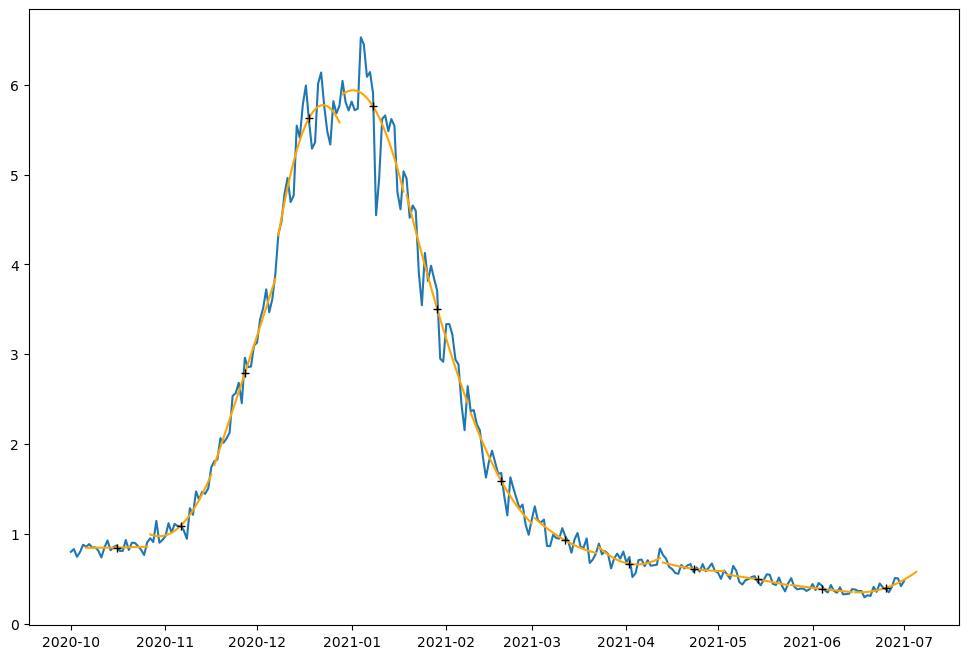

In [9]:
plot_taylor_fits(ca_data_w_deg2, taylor_degree=2, window_size=21, window_align='centered')

We can interpret the Taylor polynomial coefficient estimates at each time as estimates of the level, slope, and curvature of the signal at that time.

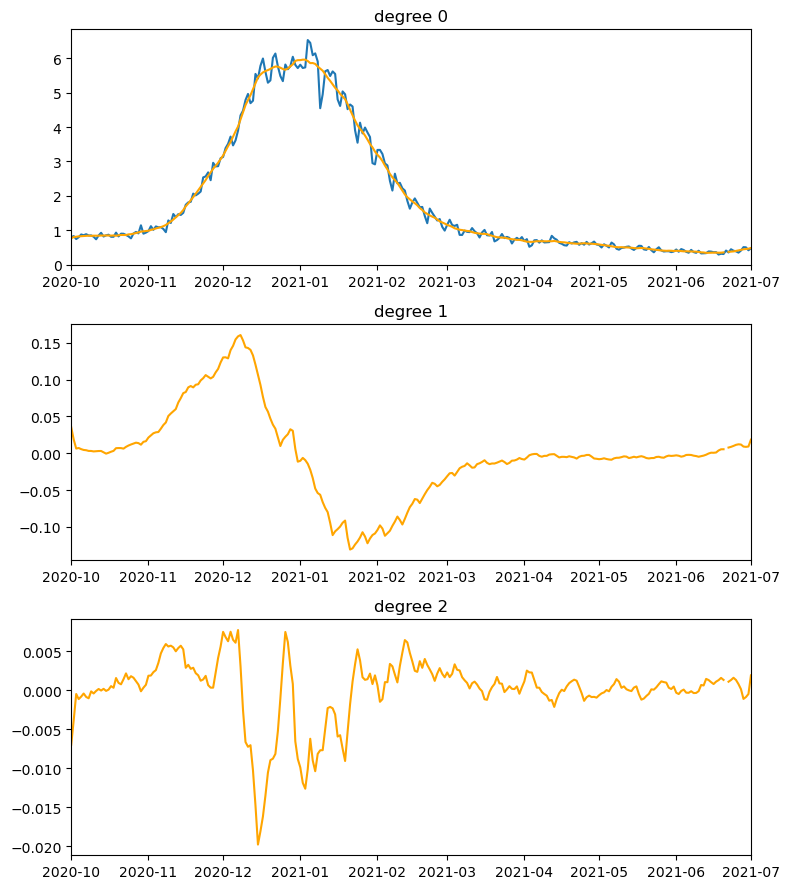

In [10]:
def stacked_taylor_coef_plot(data, taylor_degree, window_size, window_align):
    fig, ax = plt.subplots(taylor_degree + 1, 1, figsize=(8, 3 * (taylor_degree + 1)))
    
    for c in range(taylor_degree + 1):
        if c == 0:
            ax[c].plot(data.date, data.rate)
        
        ax[c].plot(data.date, data[f'rate_taylor_d{str(taylor_degree)}_c{c}_w{str(window_size) + window_align[0]}_sNone'],
                   color = 'orange')
        ax[c].set_xlim(np.min(data.date), np.max(data.date))
        ax[c].set(title=f'degree {c}')
    
    plt.tight_layout()
    plt.show()

stacked_taylor_coef_plot(data=ca_data_w_deg2, taylor_degree=2,
                         window_size=21, window_align='centered')

We can obtain smoother estimates if we use a longer window size, and in general higher-degree polynomials require longer window sizes.

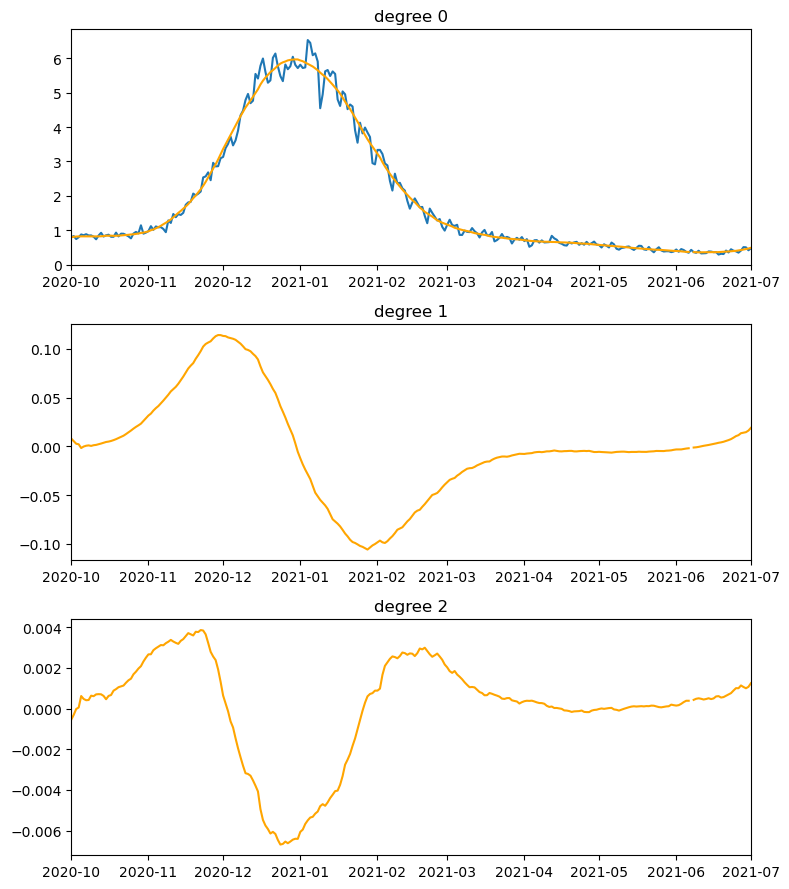

In [11]:
ca_data_w_deg2_window_49, feat_names = featurize.windowed_taylor_coefs(
    ca_data,
    columns='rate',
    taylor_degree=2,
    window_size=49,
    window_align='centered')
stacked_taylor_coef_plot(data=ca_data_w_deg2_window_49,
                         taylor_degree=2,
                         window_size=49,
                         window_align='centered')


If the Taylor coefficients are being used as summaries of the data in the context of a forecasting model, it can be helpful to use trailing windows. This ensures that the treatment of the data at the end of the series, which will be most directly used for forecasting, matches the treatment of the data in previous windows. However, the use of trailing windows can impact the reliability of trend estimates since a polynomial will tend to fit the center of the data window better than the edges. We illustrate this below:

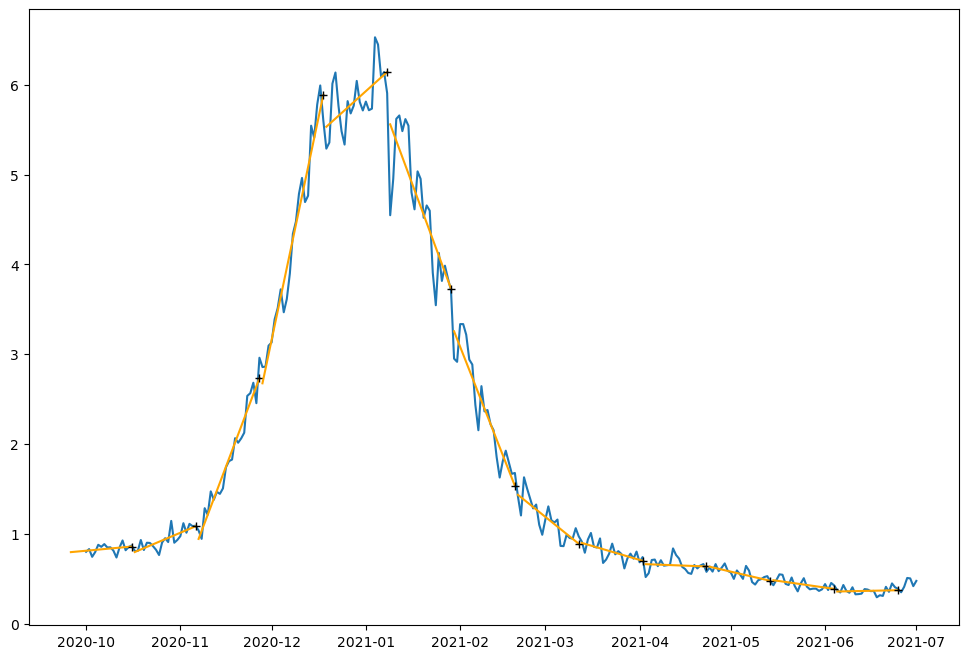

In [12]:
ca_data_w_deg1_trailing, feat_names = featurize.windowed_taylor_coefs(ca_data, columns='rate', window_align='trailing')
plot_taylor_fits(ca_data_w_deg1_trailing, taylor_degree=1, window_size=21, window_align='trailing')

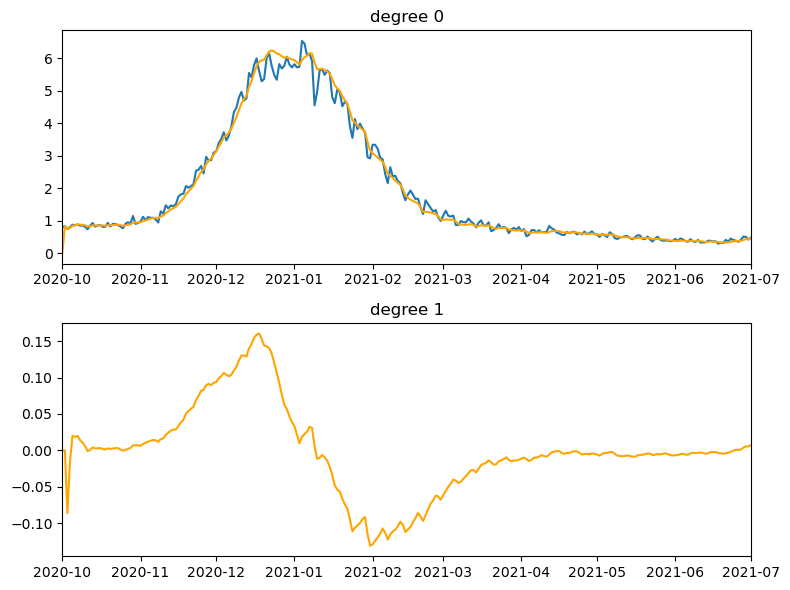

In [13]:
stacked_taylor_coef_plot(data=ca_data_w_deg1_trailing, taylor_degree=1,
                         window_size=21, window_align='trailing')

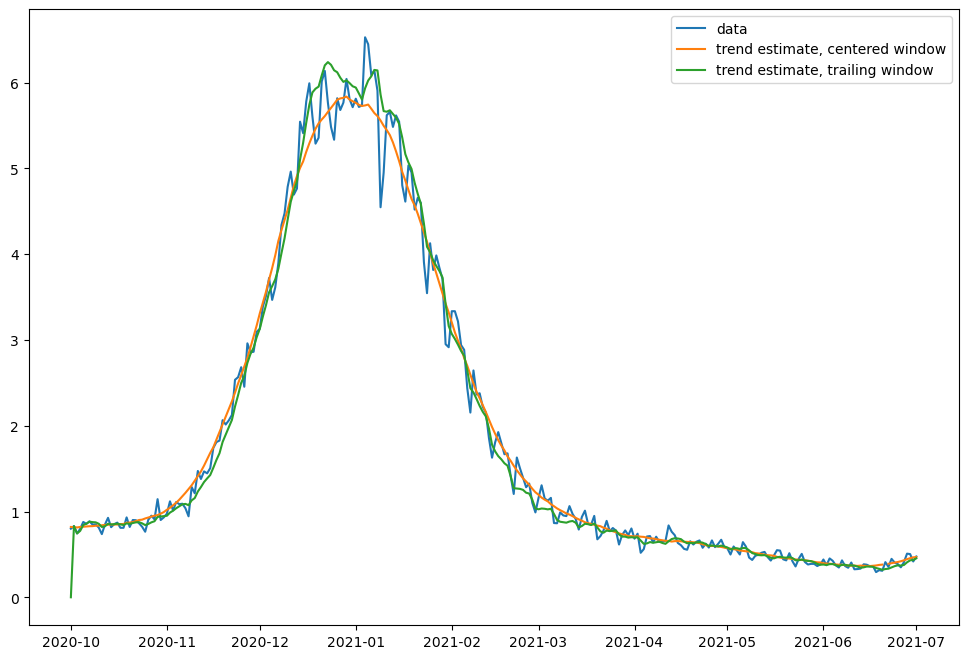

In [14]:
plt.figure(figsize = (12,8))
plt.plot(ca_data.date, ca_data.rate, label='data')
plt.plot(ca_data_w_deg1.date,
         ca_data_w_deg1.rate_taylor_d1_c0_w21c_sNone,
         label='trend estimate, centered window')
plt.plot(ca_data_w_deg1_trailing.date,
         ca_data_w_deg1_trailing.rate_taylor_d1_c0_w21t_sNone,
         label='trend estimate, trailing window')
plt.legend()

The behavior of a degree 2 polynomial with a larger window size is qualitatively similar:

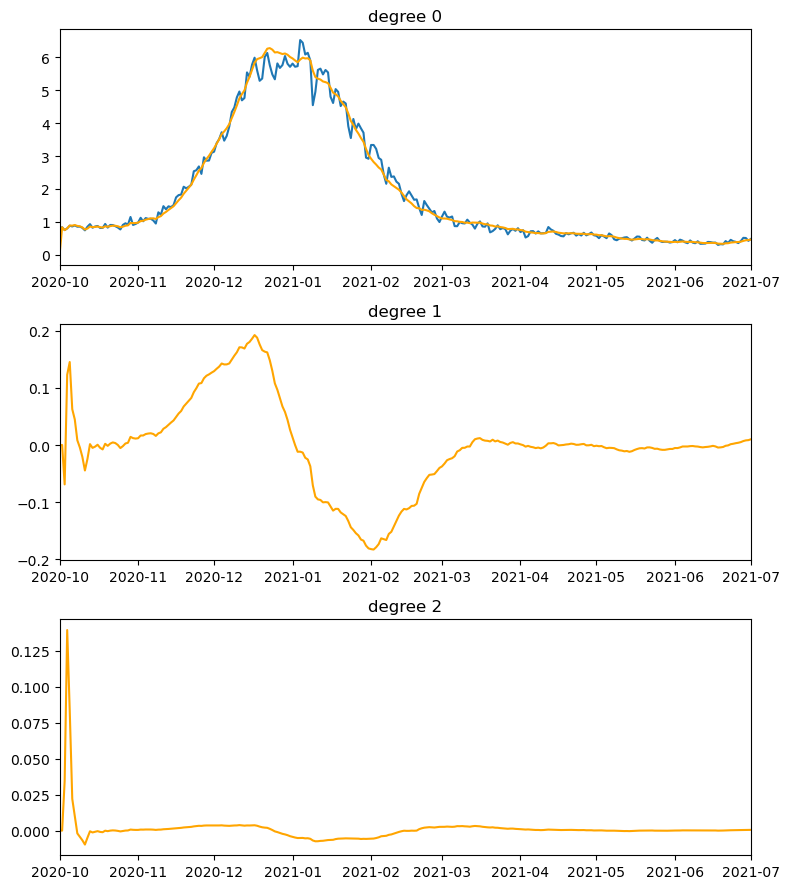

In [15]:
ca_data_w_deg2_trailing, feat_names = featurize.windowed_taylor_coefs(
    ca_data, columns='rate', taylor_degree=2,
    window_align='trailing', window_size=42)
stacked_taylor_coef_plot(data=ca_data_w_deg2_trailing, taylor_degree=2,
                         window_size=42, window_align='trailing')

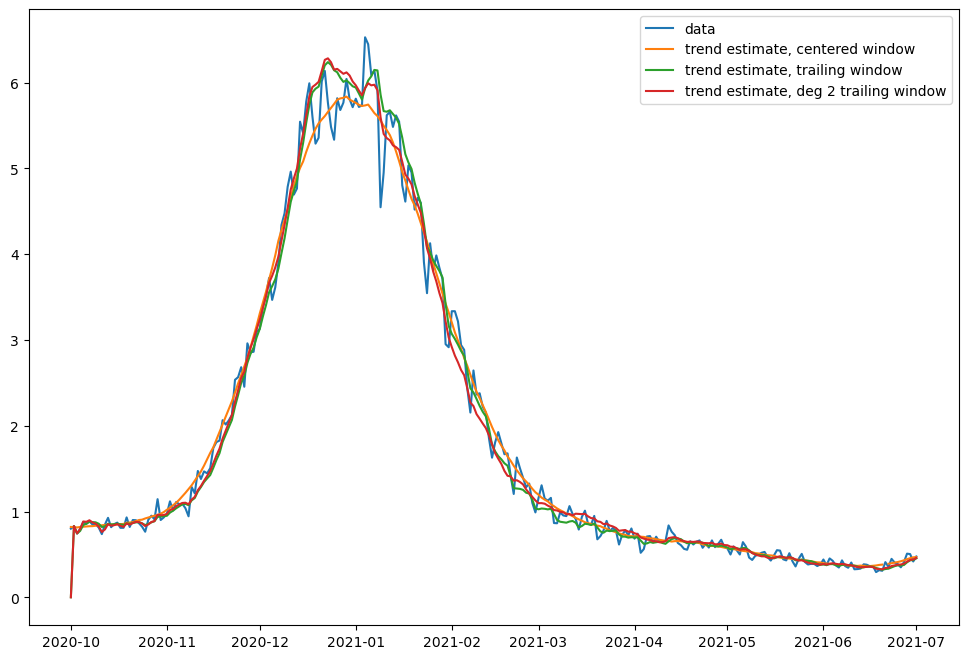

In [16]:
plt.figure(figsize = (12,8))
plt.plot(ca_data.date, ca_data.rate, label='data')
plt.plot(ca_data_w_deg1.date,
         ca_data_w_deg1.rate_taylor_d1_c0_w21c_sNone,
         label='trend estimate, centered window')
plt.plot(ca_data_w_deg1_trailing.date,
         ca_data_w_deg1_trailing.rate_taylor_d1_c0_w21t_sNone,
         label='trend estimate, trailing window')
plt.plot(ca_data_w_deg2_trailing.date,
         ca_data_w_deg2_trailing.rate_taylor_d2_c0_w42t_sNone,
         label='trend estimate, deg 2 trailing window')
plt.legend()

We can use the `featurize_data` function to perform these calculations simultaneously for all locations and compare to a simple 7 day rolling mean:

In [17]:
all_data_w_taylor_deg1, feature_names = featurize.featurize_data(
    data, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'rate',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': 42,
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'rate',
                'window_size': 7
            }
        },
        {
            'fun': 'lag',
            'args': {
                'columns': 'rate_rollmean_w7',
                'lags': [7]
            }
        }
    ])

all_data_w_taylor_deg1['empirical_deriv'] = (all_data_w_taylor_deg1['rate_rollmean_w7'] -
                                                all_data_w_taylor_deg1['rate_rollmean_w7_lag7']) / 7
all_data_w_taylor_deg1

location       date  inc_hosp  population      rate  \
0           AK 2020-10-01       3.0      731545  0.410091   
1           AK 2020-10-02       7.0      731545  0.956879   
2           AK 2020-10-03       5.0      731545  0.683485   
3           AK 2020-10-04       5.0      731545  0.683485   
4           AK 2020-10-05       1.0      731545  0.136697   
...        ...        ...       ...         ...       ...   
13969       WY 2021-06-27      10.0      578759  1.727835   
13970       WY 2021-06-28       9.0      578759  1.555051   
13971       WY 2021-06-29       7.0      578759  1.209484   
13972       WY 2021-06-30       8.0      578759  1.382268   
13973       WY 2021-07-01       3.0      578759  0.518350   

       rate_taylor_d2_c0_w42t_sNone  rate_taylor_d2_c1_w42t_sNone  \
0                               NaN                           NaN   
1                               NaN                           NaN   
2                               NaN                           NaN   
3                               NaN                           NaN   
4                               NaN                           NaN   
...                             ...                           ...   
13969                      0.949448                     -0.052961   
13970                      1.069838                     -0.033304   
13971                      1.092878                     -0.026297   
13972                      1.144384                     -0.017518   
13973                      0.979454                     -0.034750   

       rate_taylor_d2_c2_w42t_sNone  rate_rollmean_w7  rate_rollmean_w7_lag7  \
0                               NaN               NaN                    NaN   
1                               NaN               NaN                    NaN   
2                               NaN               NaN                    NaN   
3                               NaN               NaN                    NaN   
4                               NaN               NaN                    NaN   
...                             ...               ...                    ...   
13969                     -0.001925          1.209484               1.086068   
13970                     -0.000871          1.357585               0.888601   
13971                     -0.000460          1.431635               0.839234   
13972                     -0.000021          1.530368               0.765184   
13973                     -0.000831          1.357585               0.888601   

       empirical_deriv  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
13969         0.017631  
13970         0.066998  
13971         0.084629  
13972         0.109312  
13973         0.066998  

[13974 rows x 11 columns]

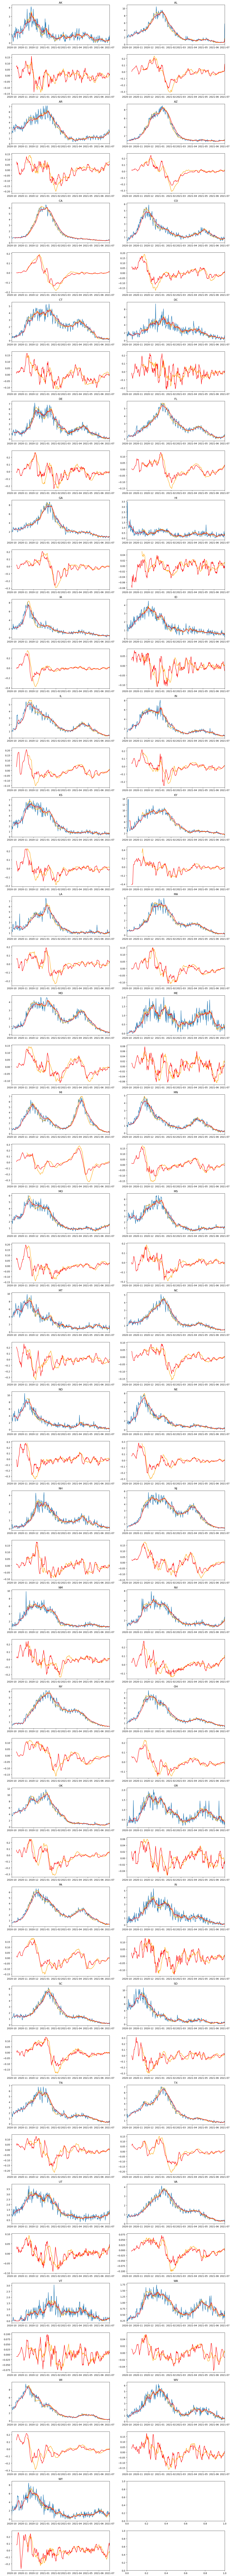

In [18]:
locations = all_data_w_taylor_deg1.location.unique()
fig_ncol = 2
fig_nrow = math.ceil(len(locations) / fig_ncol) * 2
fig, ax = plt.subplots(fig_nrow, fig_ncol, figsize=(14, 3 * fig_nrow))

for i, loc in enumerate(locations):
    row_ind = (i // fig_ncol) * 2
    col_ind = i % fig_ncol
    loc_data = all_data_w_taylor_deg1[all_data_w_taylor_deg1.location == loc]
    ax[row_ind, col_ind].plot(loc_data.date, loc_data.rate)
    ax[row_ind, col_ind].plot(loc_data.date, loc_data.rate_taylor_d2_c0_w42t_sNone, color = "orange")
    ax[row_ind, col_ind].plot(loc_data.date, loc_data.rate_rollmean_w7, color = "red")
    
    ax[row_ind + 1, col_ind].plot(loc_data.date, loc_data.rate_taylor_d2_c1_w42t_sNone, color = "orange")
    ax[row_ind + 1, col_ind].plot(loc_data.date, loc_data.empirical_deriv, color = "red")
    ax[row_ind, col_ind].set_xlim(np.min(loc_data.date), np.max(loc_data.date))
    ax[row_ind + 1, col_ind].set_xlim(np.min(loc_data.date), np.max(loc_data.date))
    ax[row_ind, col_ind].set(title=loc)

plt.tight_layout()
plt.show()